In [10]:
# Module Import
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:',DEVICE)

Using PyTorch version: 1.13.0  Device: cpu


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [7]:
# 개미와 벌을 분류하기 위해 개미 이미지 데이터와 벌 이미지 데이터 불러오기(Train Set, Test Set 분리)
data_transforms = {
    'train': transforms.Compose([transforms.RandomResizedCrop(224),  # - (1)
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                 ]),
    'val': transforms.Compose([transforms.CenterCrop(224),
                               transforms.Resize(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                               ])
}

image_datasets = {x: datasets.ImageFolder("data/hymenoptera_data", data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = BATCH_SIZE, num_workers = 0, shuffle = True) for x in ['train', 'val']}

(1) : 해당 이미지를 224 사이즈로 변경하되 변경되는 이미지 픽셀 값은 랜덤으로 선택. 이미지 내 랜덤으로 선택해 224 사이즈로 변경

In [8]:
# 데이터 확인
for (X_train, y_train) in dataloaders['train']:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

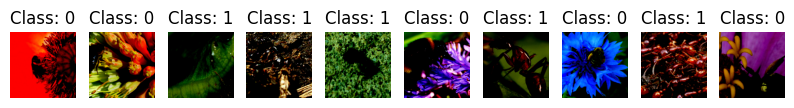

In [12]:
pltsize = 1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

제시된 10개의 이미지 데이터 각각은 224*224*3 개의 픽셀로 구성돼 있는 이미지

In [13]:
# 불러온 특정 모델에 대해 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)] \t Train Loss: {:.6f}".format(Epoch, batch_idx * len(image), len(train_loader.dataset), 100 * batch_idx / len(train_loader), loss.item()))

In [14]:
# 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100 * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [15]:
# 파이토치 내에서 제공하는 미리 학습되지 않은 ResNet18 모델 불러온 후 Ouptut 크기 설정
import torchvision.models as models  # - (1)
model = models.resnet18(pretrained = False).cuda()    # - (2)
num_ftrs = model.fc.in_features    # - (3)
model.fc = nn.Linear(num_ftrs, 2)    # - (4)
model = model.cuda()    # - (5)

/Users/hangyojeong/opt/anaconda3/envs/pytorch_test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hangyojeong/opt/anaconda3/envs/pytorch_test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AssertionError: Torch not compiled with CUDA enabled

(1) : torchvision Module의 models 내에 있는 models를 임포트
(2) : torchvision.models 내에 있는 models resnet18 모델을 불러옴.
미리 학습된 파라미터 값을 불러오는 과정은 pretrained = True 인자 값을 조정해 설정
pretrained = False이면 모델의 구조만 불러오고 모델 구조 내에 있는 파라미터는 특정 initializer에서 랜덤으로 샘플링한 값을 이용해 모델을 불러옴

학습되지 않은 즉 설정된 initializer의 분포 내에서 샘플링한 파라미터 값을 이용해 모델을 학습하는 것보다는 다른 데이터에 학습된 파라미터를 이용하는 것이 좋아 보이지만 만약 다른 데이터셋에 대해 모델이 과적합돼 정작 데이터를 분류하지 못하게 된다면 문제가 생길수 있음 But, 그렇다해도 아예 랜덤으로 설정된 파라미터 값을 이용하는것보다는 나음

본인이 이용하고자 하는 데이터와 아주 비슷한 데이터에서 학습된 모델을 이용할 수 있다면 우리가 이용하고자 하는 데이터에도 잘 작동할 가능성이 높음

(3) : torchvision.model 내에 있는 models를 이용해 불러온 모델에 대해 Fully Connected Layer를 구성하고 있는 부분에 접근
in_features는 resnet34 모델의 Fully Connected Layer의 Input에 해당하는 노드 수를 num_ftrs로 저장
(4) : resnet18 모델의 Fully Connected Layer의 Input에 해당하는 노드 수를 이용해 새로운 레이어를 추가, 개미와 벌을 분류하기 때문에 클래스 개수인 2개로 Output을 설정
(5) : 기존에 있는 모델을 불러와 새로 재구성한 모델을 학습시키기 위해 사전에 정의한 DEVICE에 할당

In [16]:
# Optimizer, Objective Function 설정
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

print(model)

NameError: name 'model' is not defined

In [ ]:
# 미리 학습되지 않은 ResNet18 학습을 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인
for Epoch in range(1, EPOCHS + 1):
    train(model, dataloaders[“train”], optimizer, log_interval = 5)  
    test_loss, test_accuracy = evaluate(model, dataloaders[“val”])  
    print(“\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n”.format(Epoch, test_loss, test_accuracy))